In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import fetch_california_housing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedShuffleSplit, \
                                    RandomizedSearchCV, \
                                    GridSearchCV
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor

In [2]:
rc = {
    'axes.grid': False,
    'axes.edgecolor': 'lightgrey',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.color': 'grey',
    'xtick.labelsize': 'small',
    'xtick.bottom': True,
    'xtick.major.size': 2.5,
    'ytick.color': 'grey',
    'ytick.major.size': 2.5,
    'ytick.left': True,
}

sns.set(style='whitegrid', rc=rc)

### Main subject

In [3]:
def indices_of_top_k(arr, k):
    """Return a sorted (in an increasing order) array 
    of indices of largest k elements of arr"""
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])


class TopKFeatureSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, feature_importances, k=None):
        self.feature_importances = feature_importances
        self.k = k or len(self.feature_importances)
        
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    
    def transform(self, X):
        return X[:, self.feature_indices_]

### Example usage

In [4]:
california_housing = fetch_california_housing()
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [5]:
cali_housing_df = pd.DataFrame(california_housing.data, columns=california_housing.feature_names)
cali_housing_df['median_house_value'] = california_housing.target

In [6]:
cali_housing_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


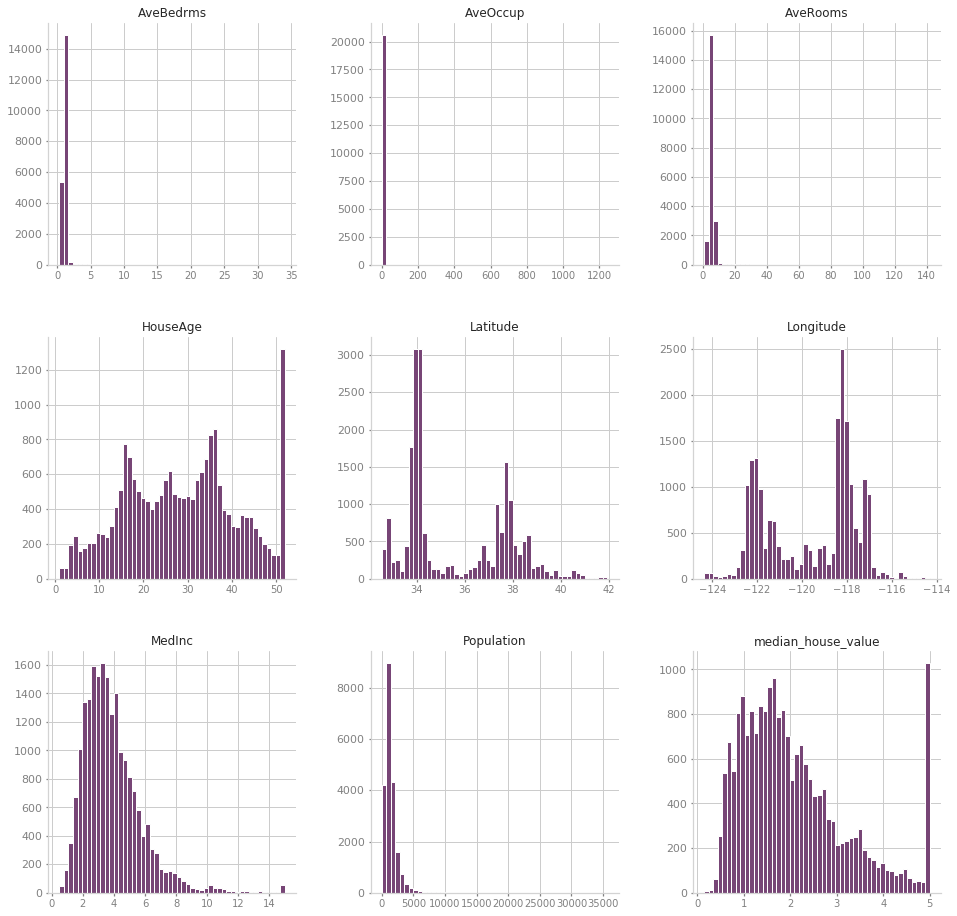

In [7]:
cali_housing_df.hist(bins=50, figsize=(16,16), color=sns.cubehelix_palette(8)[-3])
plt.show()

**Note:** `MedInc`, `HouseAge` and our target attribute `median_house_value` seem to be capped at 15.000100, 52.0 and 5.000010 respectively.

We will use `StratifiedShuffleSplit` to make sure that large fractions of target attribute at capped values do not end up in either train or test dataset - we will create a temporary category attribute to determine which in which specified quantile the target value belongs to.

In [8]:
bins = [cali_housing_df['median_house_value'].quantile(q) for q in np.linspace(0.0, 1.0, num=5, endpoint=True)]
bins = bins + [np.inf]
bins

[0.14999, 1.196, 1.797, 2.6472499999999997, 5.00001, inf]

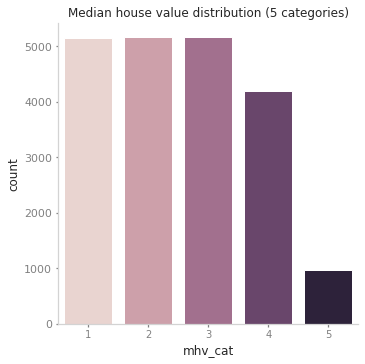

In [9]:
cali_housing_df['mhv_cat'] = pd.cut(cali_housing_df['median_house_value'],
                                    bins=bins, right=False,
                                    labels=np.arange(len(bins)-1)+1)

sns.catplot(x='mhv_cat', kind='count', data=cali_housing_df, 
            palette=sns.cubehelix_palette(len(bins)-1)) \
   .set(title=f'Median house value distribution ({len(bins)-1} categories)')

As we expected, the value counts in the newly created categories correspond to the quartiles in which their target value belongs - except in the fourth quartile, which seperates continious values from those that are capped, which are labeled as a fifth category.

We should still check if the capped target attribute values were labelled as intended.

In [10]:
capped_mhv = cali_housing_df['mhv_cat'] == 5
cali_housing_df[capped_mhv]['median_house_value'].value_counts()

5.00001    965
Name: median_house_value, dtype: int64

As we can see, only capped target attribute values belong in this category, so we are ready to perform stratified shuffle split.

In [11]:
strat_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_ix, test_ix in strat_split.split(cali_housing_df, cali_housing_df['mhv_cat']):
    X_train, X_test = california_housing.data[train_ix], california_housing.data[test_ix]
    y_train, y_test = california_housing.target[train_ix], california_housing.target[test_ix]

In [12]:
for data in (X_train, X_test, y_train, y_test):
    print(data.shape)

(16512, 8)
(4128, 8)
(16512,)
(4128,)


In [13]:
y_train

array([4.069, 2.   , 3.074, ..., 4.25 , 2.932, 1.   ])

In [14]:
cali_housing_df = pd.DataFrame(X_train, columns=california_housing.feature_names)
cali_housing_df['median_house_value'] = y_train

In [15]:
def is_capped(attr):
    return lambda x: np.abs(x - np.max(cali_housing_df[attr])) < 1e-6

for attr in ['HouseAge', 'MedInc', 'median_house_value']:
    cali_housing_df[f'is_{attr}_capped'] = cali_housing_df[attr].apply(is_capped(attr))

In [16]:
corr_matrix = cali_housing_df.corr()
np.abs(corr_matrix['median_house_value']).sort_values(ascending=False)

median_house_value              1.000000
MedInc                          0.688831
is_median_house_value_capped    0.562432
Latitude                        0.152145
AveRooms                        0.146326
is_HouseAge_capped              0.144447
is_MedInc_capped                0.113486
HouseAge                        0.104557
AveBedrms                       0.043806
Longitude                       0.037477
AveOccup                        0.024696
Population                      0.022762
Name: median_house_value, dtype: float64

In [17]:
cali_housing_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,median_house_value,is_HouseAge_capped,is_MedInc_capped,is_median_house_value_capped
0,3.9352,44.0,4.603636,1.129091,961.0,1.747273,33.76,-118.13,4.069,False,False,False
1,2.6447,42.0,5.740845,1.036620,2037.0,5.738028,37.77,-122.30,2.000,False,False,False
2,6.2685,6.0,8.010989,1.014652,697.0,2.553114,34.68,-120.44,3.074,False,False,False
3,3.1453,23.0,5.483582,0.991045,1064.0,3.176119,36.20,-119.31,0.745,False,False,False
4,5.1616,29.0,5.518024,0.993324,2023.0,2.700935,37.54,-122.00,2.751,False,False,False


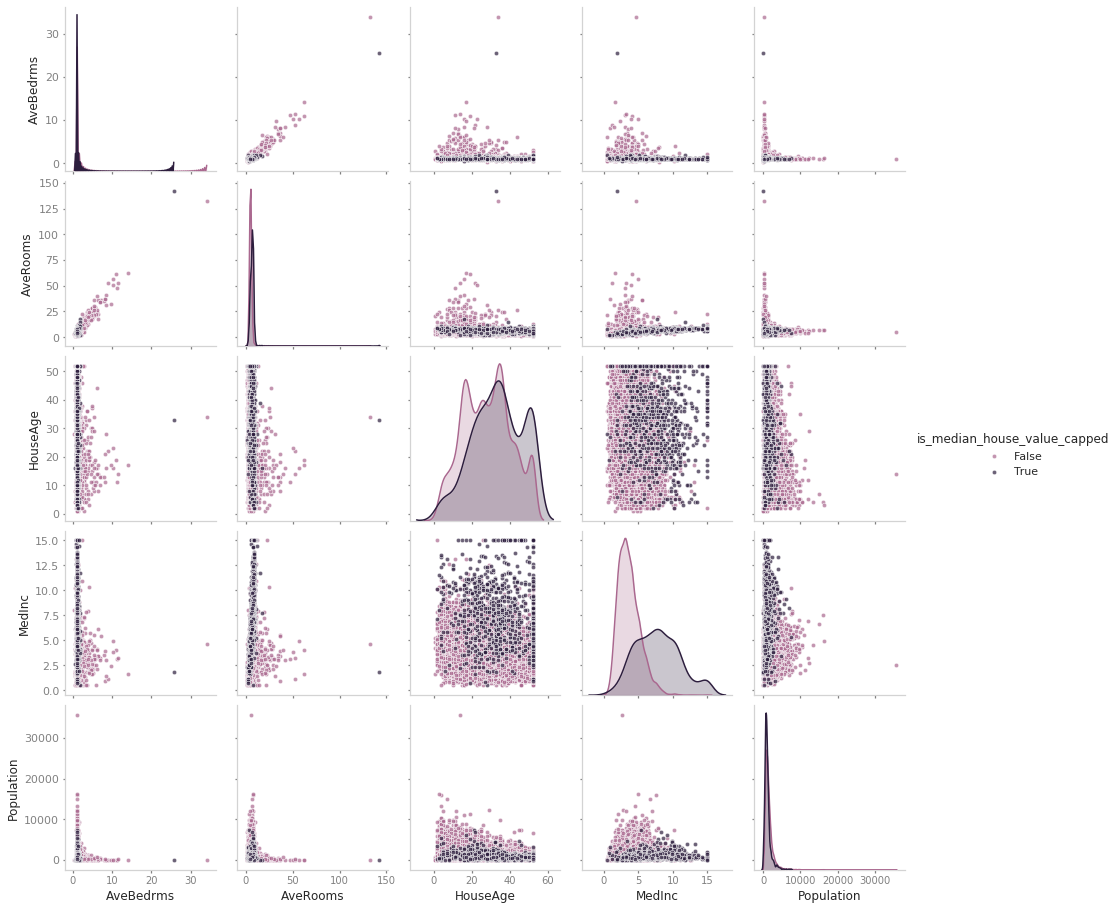

In [18]:
scatter_kws = dict(alpha=0.7, s=20)
attribs = ['AveBedrms', 'AveRooms', 'HouseAge', 'MedInc', 'Population']
hue = 'is_median_house_value_capped'

sns.pairplot(cali_housing_df, vars=attribs, diag_kind='auto', 
             kind='scatter', plot_kws=scatter_kws, hue=hue, 
             palette=sns.cubehelix_palette(n_colors=3)[1:])
plt.show()

We are looking to spot what properties make the target value capped - it seems that `MedInc` is shifted by a significant amount to the right, indicating that the most expensive houses tend to be the ones in the districts with high median income - that is true, as seen in the correlation matrix earlier. We can also notice a similar effect with `HouseAge` KDE plot, to a lesser extent.

Most expensive houses also seem to have fewer of `AveBedrms` and `AveRooms`.

Our main concern here is that we should be wary of our ML algorithm of choice to 'learn' from these capped values and try to diversify them a bit more.

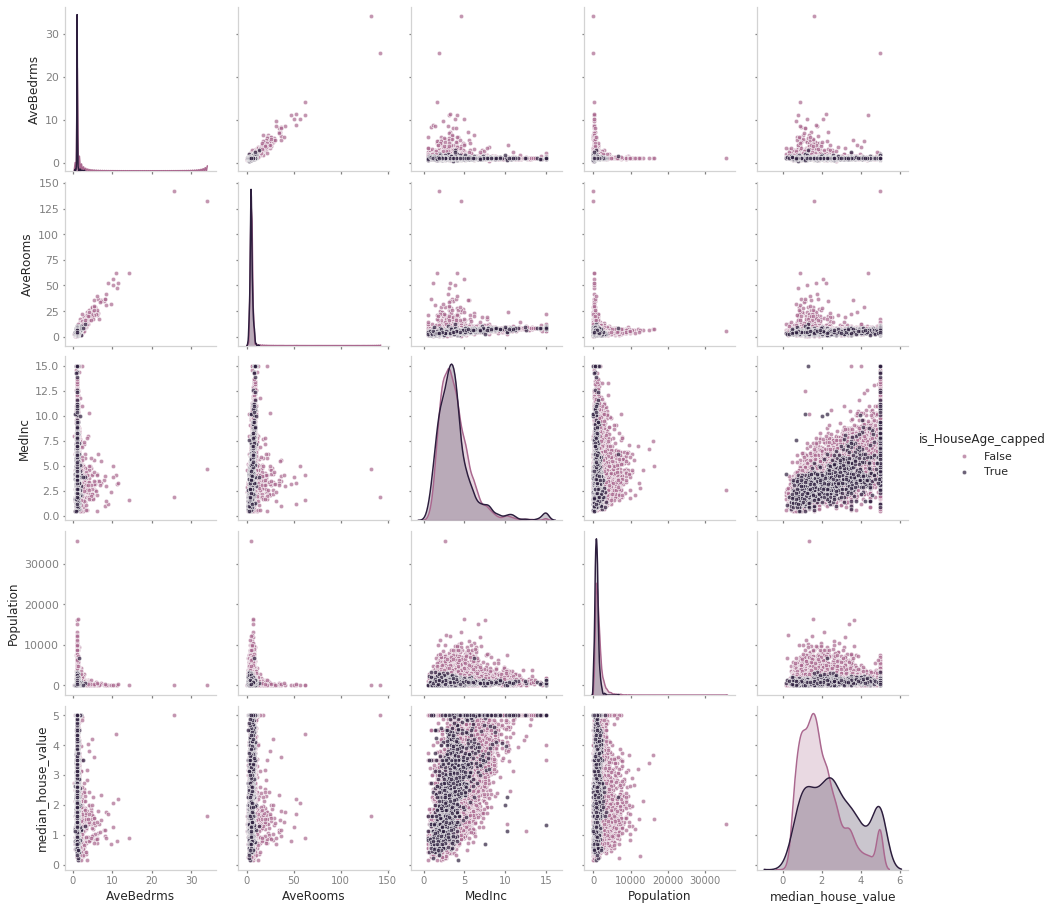

In [19]:
scatter_kws = dict(alpha=0.7, s=20)
attribs = ['AveBedrms', 'AveRooms', 'MedInc', 'Population', 'median_house_value']
hue = 'is_HouseAge_capped'

sns.pairplot(cali_housing_df, vars=attribs, diag_kind='auto', 
             kind='scatter', plot_kws=scatter_kws, hue=hue,
             palette=sns.cubehelix_palette(n_colors=3)[1:])
plt.show()

It seems that the oldest houses have fewer `AveBedrms` and `AveRooms`.

/home/lukas/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


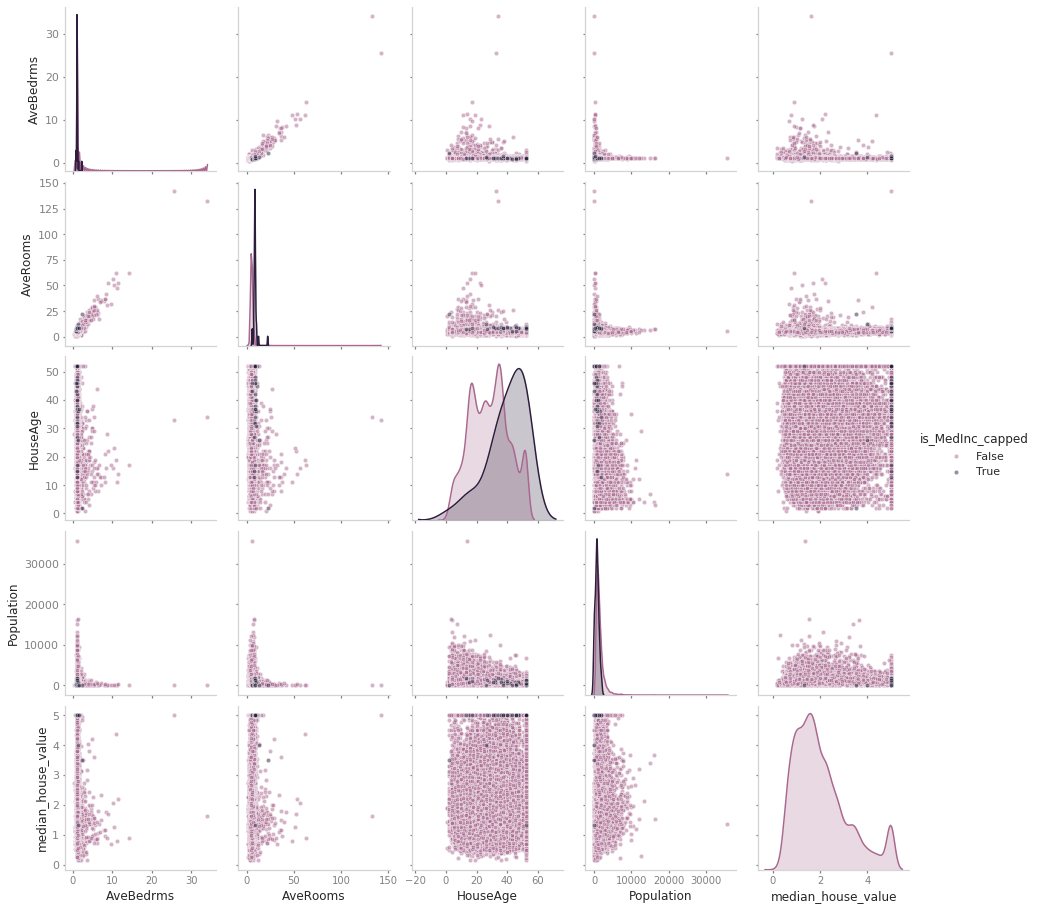

In [20]:
scatter_kws = dict(alpha=0.5, s=20)
attribs = ['AveBedrms', 'AveRooms', 'HouseAge', 'Population', 'median_house_value']
hue = 'is_MedInc_capped'

sns.pairplot(cali_housing_df, vars=attribs, diag_kind='auto', 
             kind='scatter', plot_kws=scatter_kws, hue=hue,
             palette=sns.cubehelix_palette(n_colors=3)[1:])
plt.show()

`MedInc`, our most informative attribute, seems to largery correlated with districts with older houses and slightly more `AveRooms`, but few `AveBedrms`.

Let's now explore useful attribute combinations.

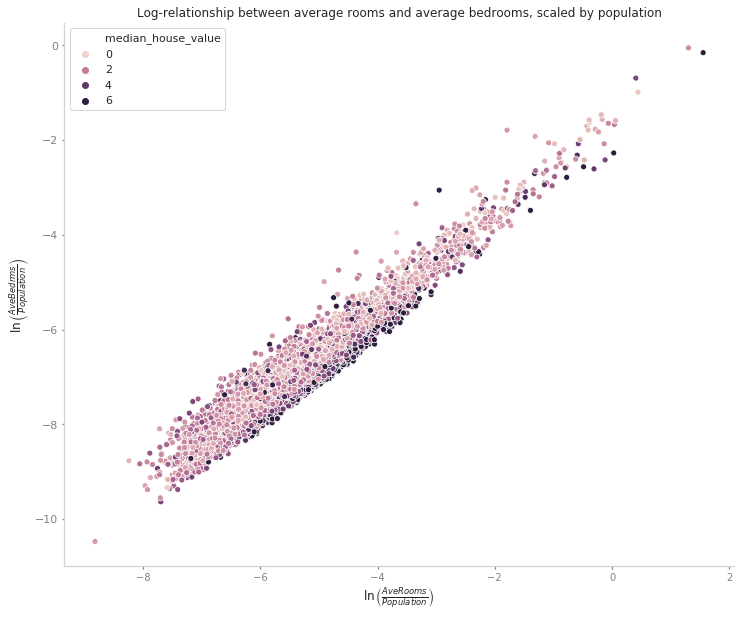

In [21]:
plt.figure(figsize=(12,10))
sns.scatterplot(x=np.log(cali_housing_df['AveRooms'] / cali_housing_df['Population']), 
                y=np.log(cali_housing_df['AveBedrms'] / cali_housing_df['Population']), 
                hue=cali_housing_df['median_house_value'])
plt.xlabel(r'$\ln\/\left(\frac{AveRooms}{Population}\right)$')
plt.ylabel(r'$\ln\/\left(\frac{AveBedrms}{Population}\right)$')
plt.title('Log-relationship between average rooms and average bedrooms, scaled by population')
plt.show()

It looks like the relationship `ln(AveRooms/Population) ~ ln(AveBedrms/Population)` is linear with constant variance, with districts with higher (or capped) `median_house_value` mostly condensed on the lower end (and slightly on the upper end) of the spectrum, meaning that the fitter linear line for most expensive houses would mostly differ by the intercept. We suspect that some sort of combination of the log of these features will be uselful.

We can try and see if this applies whether the same applies if both `AveRooms` and `AveBedrms` are normalized by `AveOccup` instead of `Population`.

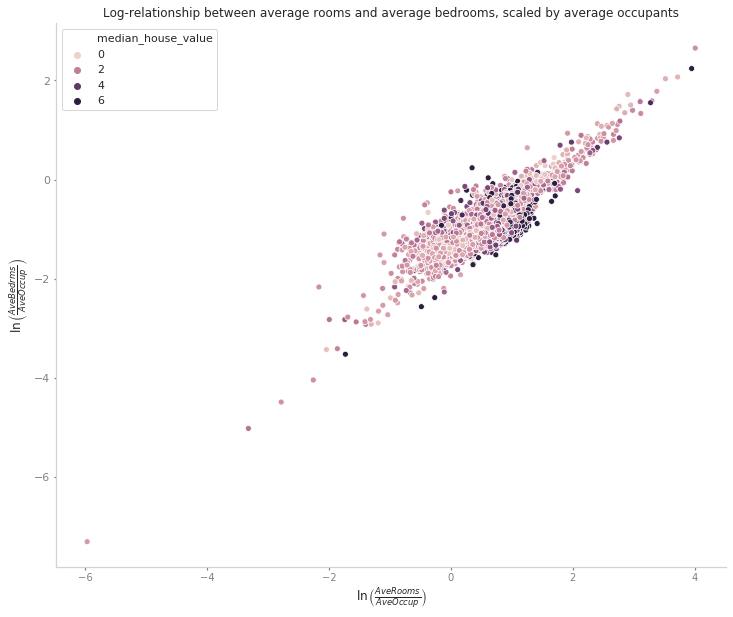

In [22]:
plt.figure(figsize=(12,10))
sns.scatterplot(x=np.log(cali_housing_df['AveRooms'] / cali_housing_df['AveOccup']), 
                y=np.log(cali_housing_df['AveBedrms'] / cali_housing_df['AveOccup']), 
                hue=cali_housing_df['median_house_value'])
plt.xlabel(r'$\ln\/\left(\frac{AveRooms}{AveOccup}\right)$')
plt.ylabel(r'$\ln\/\left(\frac{AveBedrms}{AveOccup}\right)$')
plt.title('Log-relationship between average rooms and average bedrooms, scaled by average occupants')
plt.show()

The relationship seems to maintain linearity but with non-constant variance.

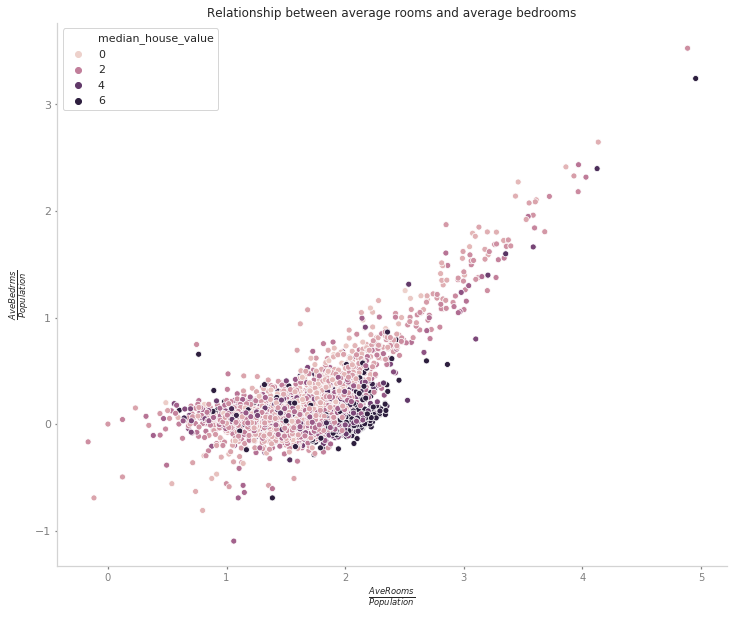

In [23]:
plt.figure(figsize=(12,10))
sns.scatterplot(x=np.log(cali_housing_df['AveRooms']), 
                y=np.log(cali_housing_df['AveBedrms']), 
                hue=cali_housing_df['median_house_value'])
plt.xlabel(r'$\frac{AveRooms}{Population}$')
plt.ylabel(r'$\frac{AveBedrms}{Population}$')
plt.title('Relationship between average rooms and average bedrooms')
plt.show()

If we don't normalize `AveRooms` and `AveBedrms` by `Population` the relationship loses linearity and it becomes harder to notice cheaper to mid-end `median_house_values` as they seem to be more mixed-up. Clusters of higher (or capped) `median_house_values` still seem to be visible with some outliers here and there.

It is becoming increasingly clear that some sort of `AveRooms` and `AveBedrms` attribute combination is informative. Let's explore it further.

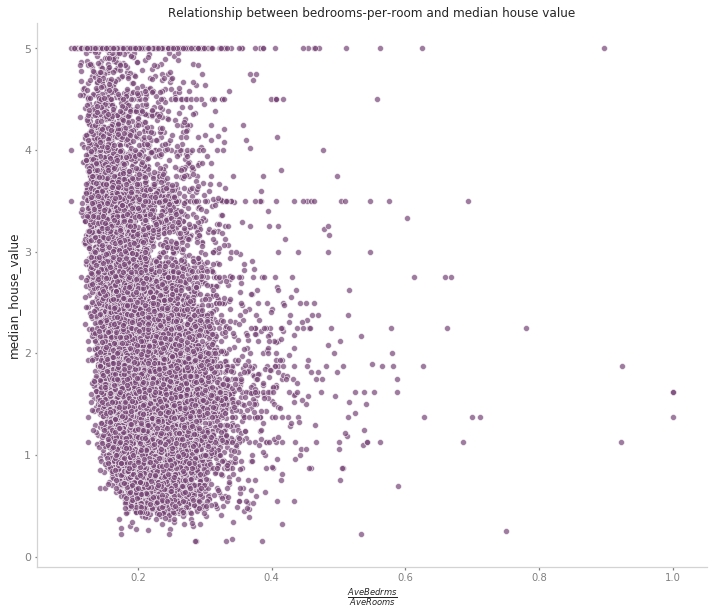

In [24]:
plt.figure(figsize=(12,10))
sns.scatterplot(x=cali_housing_df['AveBedrms'] / cali_housing_df['AveRooms'], 
                y=cali_housing_df['median_house_value'], color=sns.cubehelix_palette(8)[-3],
                alpha=0.7)
plt.xlabel(r'$\frac{AveBedrms}{AveRooms}$')
plt.title('Relationship between bedrooms-per-room and median house value')
plt.show()

The relationship `median_house_value ~ Bedrooms/Rooms` doesn't seem to vary much horizontally, meaning that the `median_house_value` of districts of the same `AveRooms / AveBedrms` ratio have high variety of our target attribute. It could be not so informative.

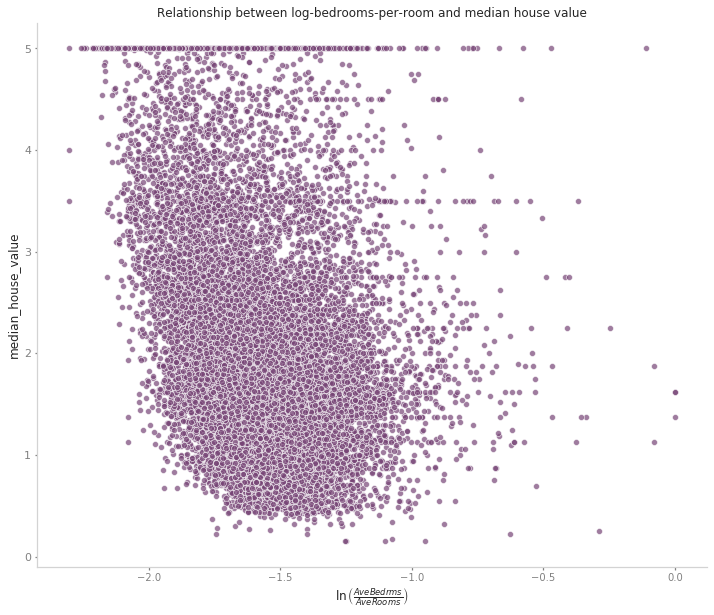

In [25]:
plt.figure(figsize=(12,10))
sns.scatterplot(x=np.log(cali_housing_df['AveBedrms'] / cali_housing_df['AveRooms']), 
                y=cali_housing_df['median_house_value'], color=sns.cubehelix_palette(8)[-3], 
                alpha=0.7, legend=None)
plt.xlabel(r'$\ln\/\left(\frac{AveBedrms}{AveRooms}\right)$')
plt.title('Relationship between log-bedrooms-per-room and median house value')
plt.show()

The `median_house_value ~ ln(AveBedrms/AveRooms` relationship seems more dispersed now - it is easier to spot differences of `median_house_value` between different ratios of explanatory variables.

Let's check the correlation between our candidate combination attributes vs our target variable.

In [26]:
rooms_per_pop = cali_housing_df['AveRooms'] / cali_housing_df['Population']
bedrooms_per_pop = cali_housing_df['AveBedrms'] / cali_housing_df['Population']
bedrooms_per_rooms = cali_housing_df['AveBedrms'] / cali_housing_df['AveRooms']

potential_features = np.array([
    rooms_per_pop, 
    np.log(rooms_per_pop), 
    bedrooms_per_pop, 
    np.log(bedrooms_per_pop),
    bedrooms_per_rooms,
    np.log(bedrooms_per_rooms),
    cali_housing_df['median_house_value']
])

potential_feature_labels = [
    'AveRooms_per_Population',
    'ln_AveRooms_per_Population',
    'AveBedrms_per_Population',
    'ln_AveBedrms_per_Population',
    'Bedrms_per_Rooms',
    'ln_Bedrms_per_Rooms'
]

potential_features_df = pd.DataFrame(potential_features.T, 
                                     columns=potential_feature_labels + ['median_house_value'])
corr_matrix = potential_features_df.corr()
np.abs(corr_matrix['median_house_value']).sort_values(ascending=False)[1:]

ln_Bedrms_per_Rooms            0.326963
Bedrms_per_Rooms               0.251830
ln_AveRooms_per_Population     0.096858
AveRooms_per_Population        0.013161
AveBedrms_per_Population       0.004917
ln_AveBedrms_per_Population    0.000202
Name: median_house_value, dtype: float64

Let's see how they compare with attributes that came with the dataset.

In [27]:
corr_matrix = cali_housing_df.iloc[:,:-3].corr()  # Except `is_<-->_capped` attributes
np.abs(corr_matrix['median_house_value']).sort_values(ascending=False)[1:]

MedInc        0.688831
Latitude      0.152145
AveRooms      0.146326
HouseAge      0.104557
AveBedrms     0.043806
Longitude     0.037477
AveOccup      0.024696
Population    0.022762
Name: median_house_value, dtype: float64

We see that the log of both `AveBedrms` per `AveRooms` and `AveRooms` per `Population` are more correlated with our target attribute than their corresponding non-log-transformed ratios. This is not the case with the ratio of `AveBedrms` per `AveBedrms`, however.

Our new top two attributes are more correlated with the target attribute than half of the original attributes. We will include them in the model together with the ratio of the new `AveBedrms` per `Population` ratio to see if our custom transformer `TopKFeatureSelector` picks it up.

It's time to set up `RandomForestRegressor` to determine feature importances for our `TopKFeatureSelector` custom transformer (which is the main subject of this notebook and example) and data preprocessing pipelines)

In [28]:
attrib_ixs = {attrib:key for key, attrib in enumerate(california_housing.feature_names)}
attrib_ixs

{'MedInc': 0,
 'HouseAge': 1,
 'AveRooms': 2,
 'AveBedrms': 3,
 'Population': 4,
 'AveOccup': 5,
 'Latitude': 6,
 'Longitude': 7}

In [29]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X_ = X.copy()
        
        ln_Bedrms_per_Rooms = np.log(X_[:, attrib_ixs['AveBedrms']] / X_[:, attrib_ixs['AveRooms']])
        ln_AveRooms_per_Population = np.log(X_[:, attrib_ixs['AveRooms']] / X_[:, attrib_ixs['Population']])
        AveBedrms_per_Population = X_[:, attrib_ixs['AveBedrms']] / X_[:, attrib_ixs['Population']]
        
        X_ = np.column_stack((X_, ln_Bedrms_per_Rooms, 
                                  ln_AveRooms_per_Population, 
                                  AveBedrms_per_Population))
        return X_    
    
attribs_CombinedAttributesAdder = ['ln_Bedrms_per_Rooms',
                                   'ln_AveRooms_per_Population',
                                   'AveBedrms_per_Population']

In [30]:
data_preprocessing_pipeline = Pipeline([
    ('attribs_adder', CombinedAttributesAdder()),
    ('robust_scaler', RobustScaler(quantile_range=(0.0, 99.0)))
])

Since we have some explanatory (and dependent - target value, named `median_house_value` in our `cali_housing_df` `pd.DataFrame`) values that are capped at their respective points, we are going to use `sklearn.preprocessing.RobustScaler` instead of `sklean.preprocessing.StandardScaler` with appropropriate `quartile_range` parameter to account for capped dependent attributes such as `HouseAge` and `MedInc` that we didn't make any further analysis of. 

It's time to transform our train data with initian pre-processing transformers and fit a `RandomForestRegressor` model which will provide feature importances for the use of our custom `TopKFeatureSelector` transformer.

In [31]:
X_train_prepared = data_preprocessing_pipeline.fit_transform(X_train)
X_train_prepared.shape

(16512, 11)

In [32]:
rforest_reg = RandomForestRegressor(random_state=42)

param_distributions = dict(
    n_estimators=randint(low=100, high=400),
    max_features=randint(low=1, high=X_train.shape[1] + len(attribs_CombinedAttributesAdder))
)

rforest_rand_search = RandomizedSearchCV(rforest_reg, param_distributions=param_distributions,
                                         n_iter=100, cv=10,
                                         scoring='neg_mean_squared_error', 
                                         return_train_score=True,
                                         verbose=10, random_state=42, n_jobs=-1)

rforest_rand_search.fit(X_train_prepared,  y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 13.7min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 15.1min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 16

RandomizedSearchCV(cv=10, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                             

In [33]:
rforest_rand_search.best_params_

{'max_features': 5, 'n_estimators': 260}

In [34]:
rforest_rand_search.best_score_

-0.24929544847787827

In [35]:
rforest_rand_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=260, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [36]:
version = '0.3'  # For when the notebook is run repeatedly
joblib.dump(rforest_rand_search.best_estimator_, f'_model_rforest_reg_{version}.pkl')

['_model_rforest_reg_0.3.pkl']

In [37]:
rforest_inital_cv_results_df = pd.DataFrame(rforest_rand_search.cv_results_)
rforest_inital_cv_results_df['rmse'] = rforest_inital_cv_results_df['mean_test_score'].apply(
    lambda x: np.sqrt(-x)
)
_feats_of_notice = ['rmse', 'param_max_features', 'param_n_estimators', 'mean_fit_time']
rforest_inital_cv_results_df.sort_values('rmse').head(25)[_feats_of_notice]

,rmse,param_max_features,param_n_estimators,mean_fit_time
10,0.499295,5,260,33.946715
17,0.499329,5,266,34.616181
7,0.499394,5,357,46.597964
64,0.499474,5,330,42.484431
44,0.499474,5,330,43.527206
77,0.499650,5,324,41.298490
16,0.499844,5,234,30.561528
54,0.500115,5,230,27.934303
84,0.500138,5,212,25.458585
65,0.500308,4,112,12.450720


It looks like our `RandomForestRegressor` models work best with 4-5 `param_max_features` and around 200-400 `param_n_estimators` as hyperparameter values.

In [38]:
rforest_inital_cv_results_df[_feats_of_notice].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   rmse                100 non-null    float64
 1   param_max_features  100 non-null    object 
 2   param_n_estimators  100 non-null    object 
 3   mean_fit_time       100 non-null    float64
dtypes: float64(2), object(2)
memory usage: 3.2+ KB


It seems as both `param_max_features` and `param_n_estimators` are encoded as strings in our `rforest_inital_cv_results_df` DataFrame - we need to convert them to numerical values in order to check their summary statistics.

In [39]:
for attrib in ['param_max_features', 'param_n_estimators']:
    rforest_inital_cv_results_df[attrib] = rforest_inital_cv_results_df[attrib].astype(np.int16)

In [40]:
rforest_inital_cv_results_df[_feats_of_notice].describe()

,rmse,param_max_features,param_n_estimators,mean_fit_time
count,100.000000,100.000000,100.000000,100.000000
mean,0.512415,5.620000,261.010000,37.212455
std,0.022953,2.891227,83.003285,20.713796
min,0.499295,1.000000,101.000000,3.763493
25%,0.502902,3.000000,194.000000,21.005995
50%,0.504033,6.000000,270.000000,34.475111
75%,0.506134,8.000000,327.000000,53.577038
max,0.584216,10.000000,393.000000,85.739875


We see a trend that the best hyperparameter range of `param_max_features` tends to be 4-6, so we need to check if estimators with similar range of `param_max_features` were tested that had similar `param_n_estimators` values as our best estimator.

In [41]:
high_param_n_estimators = rforest_inital_cv_results_df['param_n_estimators'] > 200
best_param_max_features = rforest_inital_cv_results_df['param_max_features'].between(4, 5, inclusive=True)

In [42]:
rforest_inital_cv_results_df[high_param_n_estimators][_feats_of_notice].sort_values('rmse')

,rmse,param_max_features,param_n_estimators,mean_fit_time
10,0.499295,5,260,33.946715
17,0.499329,5,266,34.616181
7,0.499394,5,357,46.597964
64,0.499474,5,330,42.484431
44,0.499474,5,330,43.527206
...,...,...,...,...
19,0.521877,2,364,23.130463
72,0.580390,1,382,14.844613
99,0.580935,1,300,10.478671
95,0.580999,1,354,13.203013


In [43]:
rforest_inital_cv_results_df[high_param_n_estimators & best_param_max_features]\
                            [_feats_of_notice].sort_values('rmse')

,rmse,param_max_features,param_n_estimators,mean_fit_time
10,0.499295,5,260,33.946715
17,0.499329,5,266,34.616181
7,0.499394,5,357,46.597964
44,0.499474,5,330,43.527206
64,0.499474,5,330,42.484431
77,0.499650,5,324,41.298490
16,0.499844,5,234,30.561528
54,0.500115,5,230,27.934303
84,0.500138,5,212,25.458585
2,0.500425,5,202,24.516441


We see that models with hyperparmater `param_n_estimators` values higher than 200 works best with `param_max_features` set to 5, but it's unclear what remains the best range of `param_n_estimators`.

To get a clearer look, we can draw a plot comparing selected combinations of `param_n_estimators` and `param_max_features` to see if there are any clear trends.

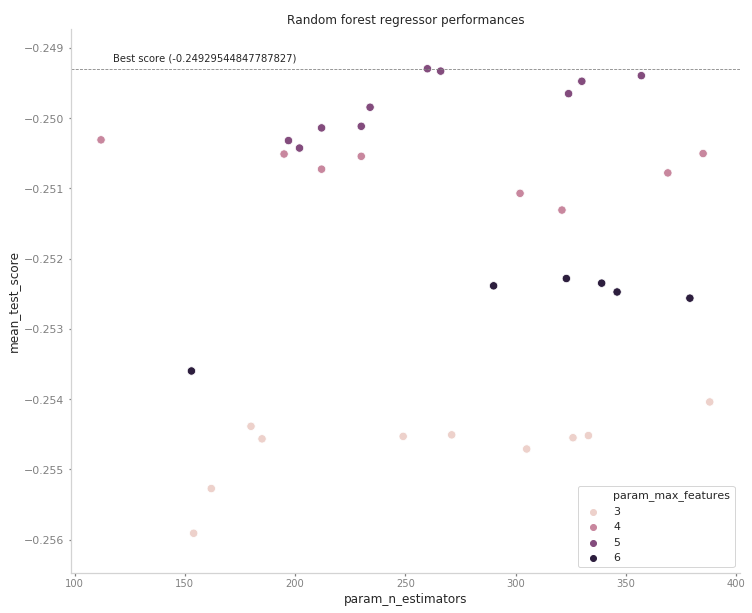

In [44]:
param_max_features_3_to_6 = rforest_inital_cv_results_df['param_max_features'].between(3, 6, inclusive=True)

plt.figure(figsize=(12,10))
plt.axhline(y=rforest_rand_search.best_score_, ls='--', lw=0.8, c='grey')
sns.scatterplot(x='param_n_estimators', y='mean_test_score', hue='param_max_features',
                data=rforest_inital_cv_results_df[param_max_features_3_to_6], s=70, 
                palette=sns.cubehelix_palette(4))

plt.annotate(f'Best score ({rforest_rand_search.best_score_})', xy=(0.15, 0.9), xycoords='figure fraction',
             fontsize='small')
plt.title('Random forest regressor performances')
plt.show()

We can see clearly that models with `param_max_features` values of 3 and 6 perform clearly worse than those with 4 or 5.

Of those models with `param_max_features` values 5, the performance increases and remain stable around `param_n_estimators` value of 250. 

It's also worth noting that the models with highest `param_n_estimators` were trained with suboptimal `param_max_features` values of {3,4,6} and a better performing model may be found with `param_n_estimators` value of 5.

We conclude that our initial `RandomizedSearchCV` are satisfactory enough to proceed.

Next we will explore feature importances.

In [45]:
all_attribs = california_housing.feature_names + attribs_CombinedAttributesAdder
all_attribs

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude',
 'ln_Bedrms_per_Rooms',
 'ln_AveRooms_per_Population',
 'AveBedrms_per_Population']

In [46]:
sorted(zip(rforest_rand_search.best_estimator_.feature_importances_, all_attribs), reverse=True)

[(0.3939308212137744, 'MedInc'),
 (0.11950786433929773, 'AveOccup'),
 (0.10243027220611982, 'Latitude'),
 (0.10111235337405898, 'ln_Bedrms_per_Rooms'),
 (0.09923164696339555, 'Longitude'),
 (0.05395674494871261, 'AveRooms'),
 (0.05213358662701649, 'HouseAge'),
 (0.025350746104630926, 'AveBedrms'),
 (0.01832557457298016, 'ln_AveRooms_per_Population'),
 (0.017178830127273732, 'Population'),
 (0.016841559522739573, 'AveBedrms_per_Population')]

Let's check how that compares to correlation coefficients to the target variable in our transformed train data.

In [47]:
cali_housing_transformed_df = pd.DataFrame(X_train_prepared, columns=all_attribs)
cali_housing_transformed_df['median_house_value'] = cali_housing_df['median_house_value']

corr_matrix_transformed = cali_housing_transformed_df.corr()
np.abs(corr_matrix_transformed['median_house_value']).sort_values(ascending=False)[1:]

MedInc                        0.688831
ln_Bedrms_per_Rooms           0.326963
Latitude                      0.152145
AveRooms                      0.146326
HouseAge                      0.104557
ln_AveRooms_per_Population    0.096858
AveBedrms                     0.043806
Longitude                     0.037477
AveOccup                      0.024696
Population                    0.022762
AveBedrms_per_Population      0.004917
Name: median_house_value, dtype: float64

The biggest difference seems to be `AveOccup` - it's second most imporant feature in our random forest model but has second worst correlation coefficient with the target attribute, as seen in the correlation matrix.

Our log-transformed new attributes seem to be less important in our model than what their correlation coefficient implies, and `AveBedrms_per_Population` attribute seems not very useful as predicted.

P.S. The default attributes' correlation coefficients haven't changed from our previously computed ones; This is because scaling doesn't affect correlation.

In [48]:
np.abs(corr_matrix['median_house_value']).sort_values(ascending=False)[1:]

MedInc        0.688831
Latitude      0.152145
AveRooms      0.146326
HouseAge      0.104557
AveBedrms     0.043806
Longitude     0.037477
AveOccup      0.024696
Population    0.022762
Name: median_house_value, dtype: float64

Let's set up final preparation pipelines and make use of our `TopKFeatureSelector` custom transformer.

In [49]:
rforest_reg = rforest_rand_search.best_estimator_

prep_select_predict_pipeline = Pipeline([
    ('preparation', data_preprocessing_pipeline),
    ('feature_selection', TopKFeatureSelector(rforest_reg.feature_importances_)),
    ('rand_forest_reg', RandomForestRegressor(**rforest_reg.get_params()))
])

In [50]:
param_grid = [{
    'preparation__robust_scaler__quantile_range': [(25.0, 75.0), (10.0, 90.0), (0.0, 99.0)],
    'feature_selection__k': range(rforest_reg.max_features, len(all_attribs)+1)
}]

prep_select_predict_grid_search = GridSearchCV(prep_select_predict_pipeline, param_grid=param_grid,
                                               scoring='neg_mean_squared_error', n_jobs=-1, cv=10,
                                               verbose=10, return_train_score=True)

prep_select_predict_grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  9.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 10.1min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 11.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 12

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('preparation',
                                        Pipeline(memory=None,
                                                 steps=[('attribs_adder',
                                                         CombinedAttributesAdder()),
                                                        ('robust_scaler',
                                                         RobustScaler(copy=True,
                                                                      quantile_range=(0.0,
                                                                                      99.0),
                                                                      with_centering=True,
                                                                      with_scaling=True))],
                                                 verbose=False)),
                                       ('feature_selec

In [51]:
prep_select_predict_grid_search.best_params_

{'feature_selection__k': 6,
 'preparation__robust_scaler__quantile_range': (25.0, 75.0)}

As we can see, the grid search we did found that our random forest regressor worked best with 6 features instead of 11, as trained previously.

It also seems like the best `quantile_range` parameter for our `RobustScaler` in our `data_preprocessing_pipeline` pipeline is also the default value of `(25.0, 75.0)` and not `(0.0, 99.0)` as we defined previously - we were trying to minimize the impact (for our feature scaling) of capped values of features like `MedInc` and `HouseAge`, but it seems that previously defined `quantile_range` value was too extreme.

We should look at the cross-validation results in our grid search results for more insight.

In [52]:
top_k_feat_cv_results_df = pd.DataFrame(prep_select_predict_grid_search.cv_results_)
top_k_feat_cv_results_df['rmse'] = top_k_feat_cv_results_df['mean_test_score'].apply(
    lambda x: np.sqrt(-x)
)
top_k_feat_cv_results_df.rename(columns={
    'param_feature_selection__k':'num_features',
    'param_preparation__robust_scaler__quantile_range':'quantile_range'
}, inplace=True)
top_k_feat_cv_results_df['num_features'] = top_k_feat_cv_results_df['num_features'].astype(np.int16)

_feats_of_notice = ['rmse', 'num_features', 'quantile_range', 'mean_fit_time', 'mean_test_score']
top_k_feat_cv_results_df.sort_values('rmse')[_feats_of_notice]

,rmse,num_features,quantile_range,mean_fit_time,mean_test_score
3,0.496489,6,"(25.0, 75.0)",31.014459,-0.246501
4,0.496491,6,"(10.0, 90.0)",30.745782,-0.246503
5,0.496510,6,"(0.0, 99.0)",30.655374,-0.246522
2,0.496694,5,"(0.0, 99.0)",29.972626,-0.246704
0,0.496704,5,"(25.0, 75.0)",29.363999,-0.246715
1,0.496742,5,"(10.0, 90.0)",29.994632,-0.246752
8,0.499259,7,"(0.0, 99.0)",29.567514,-0.249260
6,0.499261,7,"(25.0, 75.0)",29.659464,-0.249262
19,0.499277,11,"(10.0, 90.0)",31.755337,-0.249278
20,0.499288,11,"(0.0, 99.0)",28.810458,-0.249289


It seems to be that the best `quantile_range` for our `RobustScaler` is `(25.0,75.0)` with the optimal value `num_features` of 6, but the difference is miniscule.

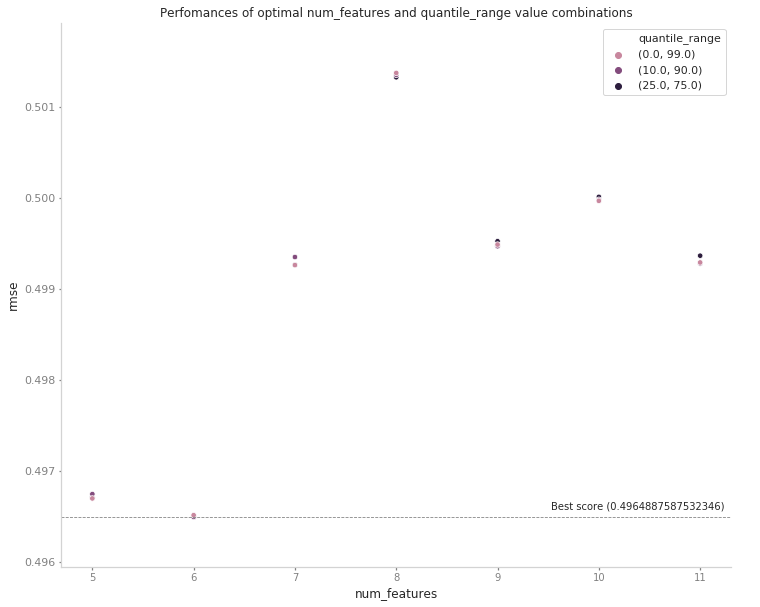

In [53]:
plt.figure(figsize=(12,10))
best_score = np.min(top_k_feat_cv_results_df['rmse'])

plt.axhline(y=best_score, ls='--', lw=0.8, c='grey')
ax = sns.scatterplot(x='num_features', y='rmse', hue='quantile_range',
                     data=top_k_feat_cv_results_df, s=30, 
                     palette=sns.cubehelix_palette(4)[1:])

plt.annotate(f'Best score ({best_score})',
             xy=(0.725, 0.16), xycoords='figure fraction', fontsize='small')
plt.title('Perfomances of optimal num_features and quantile_range value combinations')
plt.show()

The difference between top few performing models is really miniscule, so we will test all three and the initial model that our `RandomizedSearchCV` found.

In [55]:
test_predictions_df = pd.DataFrame(y_test, columns=['y_test'])

X_test_transformed = data_preprocessing_pipeline.transform(X_test)
test_predictions_df['intial_rand_search'] = rforest_reg.predict(X_test_transformed)

top_k_models_to_test = 6

for params in top_k_feat_cv_results_df.sort_values('rmse')[:top_k_models_to_test]['params']:
    _k = params['feature_selection__k']
    _qr = params['preparation__robust_scaler__quantile_range']
    test_predictions_df[f'k={_k}_qr={_qr}'] = prep_select_predict_pipeline.set_params(**params) \
                                                                          .fit(X_train, y_train) \
                                                                          .predict(X_test)

In [66]:
test_predictions_df.head(10)

,y_test,intial_rand_search,"k=6_qr=(25.0, 75.0)","k=6_qr=(10.0, 90.0)","k=6_qr=(0.0, 99.0)","k=5_qr=(0.0, 99.0)","k=5_qr=(25.0, 75.0)","k=5_qr=(10.0, 90.0)"
0,1.93900,1.735827,1.761177,1.761177,1.759196,1.773577,1.774958,1.774958
1,5.00001,4.671018,4.613202,4.625791,4.613202,4.887789,4.887789,4.892020
2,2.25600,2.359646,2.627835,2.627835,2.627120,2.461619,2.461619,2.461619
3,0.75100,0.794442,0.808358,0.805204,0.805354,0.794031,0.796058,0.794031
4,0.79200,1.038673,1.077115,1.076015,1.076015,1.126815,1.126985,1.126815
5,5.00001,3.777745,4.407803,4.390219,4.400519,4.454912,4.471727,4.443758
6,2.79400,2.852823,2.812581,2.812581,2.812581,2.696877,2.696877,2.696877
7,0.99800,1.096023,0.896919,0.896919,0.896919,0.926731,0.926731,0.926731
8,0.99000,1.295415,1.201185,1.201185,1.201185,1.179823,1.179823,1.179823
9,1.17100,1.433088,1.465612,1.465612,1.465612,1.402250,1.400185,1.400185


We now have a `DataFrame` of each individual prediction. This will come in handy when we make residual plots to see where we made the largest errors. Let's now check what is the `mean_squared_error` for the entire test (or *holdout* set) for each model.

In [198]:
results_col = test_predictions_df.columns[1:]
data = np.array([mean_squared_error(test_predictions_df.y_test, test_predictions_df[col]) 
                    for col in results_col])

model_results_series = pd.Series(index=results_col, data=data, name='model results')

model_results_series.sort_values(inplace=True)
model_results_series

k=6_qr=(0.0, 99.0)     0.235082
k=6_qr=(10.0, 90.0)    0.235160
k=6_qr=(25.0, 75.0)    0.235176
k=5_qr=(0.0, 99.0)     0.236179
k=5_qr=(10.0, 90.0)    0.236248
k=5_qr=(25.0, 75.0)    0.236319
intial_rand_search     0.238940
Name: model results, dtype: float64

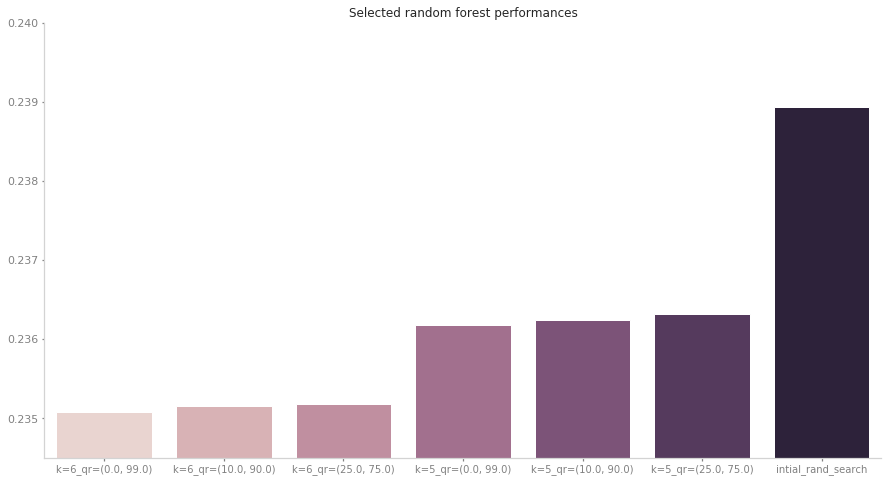

In [205]:
plt.figure(figsize=(15, 8))

sns.barplot(x=model_results_series.index,
            y=model_results_series.values,
            palette=sns.cubehelix_palette(model_results_series.size)) \
   .set(title=f'Selected random forest performances')

plt.ylim(bottom = 0.2345, top=0.24)
plt.show()


In [207]:
model_errors_df = pd.DataFrame()

for col in test_predictions_df.columns[1:]:
    model_errors_df[col] = (test_predictions_df['y_test'] - test_predictions_df[col]) ** 2
    
model_errors_df

,intial_rand_search,"k=6_qr=(25.0, 75.0)","k=6_qr=(10.0, 90.0)","k=6_qr=(0.0, 99.0)","k=5_qr=(0.0, 99.0)","k=5_qr=(25.0, 75.0)","k=5_qr=(10.0, 90.0)"
0,0.041279,0.031621,0.031621,0.032329,0.027365,0.026910,0.026910
1,0.108236,0.149620,0.140040,0.149620,0.012594,0.012594,0.011662
2,0.010743,0.138261,0.138261,0.137730,0.042279,0.042279,0.042279
3,0.001887,0.003290,0.002938,0.002954,0.001852,0.002030,0.001852
4,0.060848,0.081291,0.080665,0.080665,0.112101,0.112215,0.112101
...,...,...,...,...,...,...,...
4123,0.001038,0.045047,0.045047,0.039187,0.037646,0.047756,0.047756
4124,0.039925,0.034128,0.035405,0.034325,0.101029,0.099776,0.100731
4125,0.071589,0.007809,0.007809,0.007809,0.005915,0.005939,0.005900
4126,0.034824,0.048843,0.048843,0.048843,0.053349,0.053349,0.053349


### Notes

1. `indices_of_top_k_features(arr, k)`

Let's say we have an array of some *feature importances*:

In [ ]:
test_features = np.array([7.59313847e-02, 6.89681802e-02, 3.28467472e-02, 1.28419617e-02,
                          1.28872822e-02, 1.29153722e-02, 1.28097721e-02, 2.94243982e-01,
                          6.15642653e-02, 5.09300068e-02, 2.45449746e-02, 5.03307118e-02,
                          1.62242114e-02, 4.81002610e-02, 3.06469467e-02, 1.96957932e-02,
                          1.64905983e-01, 1.06574723e-04, 2.78914349e-03, 6.71644572e-03])

pd.DataFrame(test_features)

The function `indices_of_top_k_features(arr, k)` returns the indices of top k elements' indices, in increasing order of the index itself:

In [ ]:
top_5_features_ix = indices_of_top_k_features(test_features, 5)
top_5_features_ix

This doesn't mean the values of the passed array are sorted themselves:

In [ ]:
top_5_features = test_features[top_5_features_ix]
top_5_features

We can check if there are any other values in the passed array that are larger than the ones accessed by the retuned indices to see if our function worked correctly.

In [ ]:
any(test_features[~top_5_features_ix] > top_5_features)

Since there are no elements larger than our specified `k`th element in the left partition, we know our code worked correctly.

2. `np.argpartition`

`np.argpartition` partitions the array according to the specified *k*th element - all smaller elements than the *k*th element will be moved to the left and all larger elements will be moved to the right - all in unspecified order, except for *k*th element - it will be correctly the *k*th largest element in the specified *k*th position.

In [ ]:
test_features_argpartinioned = np.argpartition(test_features, -5)
test_features_argpartinioned

We can check whether the arguments were correctly partitioned by using reverse `np.argsort` and displaying it in a dataframe together with feature importances:

In [ ]:
test_features_df = pd.DataFrame(test_features[test_features_argpartinioned], columns=['feat_importance'])
test_features_df['importance_rank'] = np.argsort(test_features[test_features_argpartinioned][::-1]) + 1
test_features_df

We can see the the bottom fifth feature importance score is in correct position, as shown by **importance_rank** column. All other feature importance scores to the either side of the the fifth most important score are in arbitrary order.